# Projeto Sprint 8

Objetivo: Criar um modelo treinado que possa recomendar Novos Planos para clientes mais antigos da Empresa Megaline.

Observações: Tive um problema para carregar o arquivo dos datasets da tripleten. Pelo que eu entendi do erro, o caminho utilizado estava errado ou o arquivo não existia no dataset. A sintaxe estava correta e o caminho foi copiado e colado da descrição do projeto, enão realmente não sei o que estava acontecendo. A solução foi baixar o arquivo e tocar o projeto de um notebook da minha própria máquina. Não sei se era a solução mais simples, mas funcionou. Seguimos assim.

## 1. Carregamento e Análise de Dados

Nesse primeiro passo, vamos carregar os dados, chamar o método info e avaliar as colunas e mais informações. Nosso objetivo aqui é verificar se existem dados ausentes e se todos os tipos de dados estão corretos, para entregarmos uma tabela limpa para o modelo que vamos treinar.

In [160]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

Aqui, fizemos a importação do Pandas e das bibliotecas que usaremos para a criação e verificação dos modelos

### 1.1 Carregando e Analisando os Dados

In [101]:
df = pd.read_csv('C:/Users/legam/Downloads/users_behavior.csv')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [103]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Ao analisarmos o info e o head, percebemos que não temod valores faltantes na tabela, o que é ótimo e economiza trabalho. Ainda assim, nos tipos de dados, percebemos que a coluna chamada e a coluna mensagens estão como float. O mais correto seria t~e-las como int, porque, aparentemente, todos os valores terminam com 0 como decimal. Os modelos treinados trabalham bem com os dois tipos, mas manter o tipo int pode economizar memória. Antes de alterar, só vou verificar se todas as linhas realmente terminam com .0 como decimal.

Além disso, vamos converter a coluna "is_ultra" para booleano. Ela não precisa ser int se só tem função de classificar os planos e se só retorna 0 e 1.

In [105]:
print((df['calls'] % 1 == 0).all())
print((df['messages'] % 1 == 0).all()) 

True
True


O resultado "True" para ambas as linhas indica que todos os dados terminam com decimal 0. Podemos converter para o tipo inteiro então.

In [107]:
df['calls'] = df['calls'].astype(int)
df['messages'] = df['calls'].astype(int)
df['is_ultra'] = df['is_ultra'].astype(bool)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   bool   
dtypes: bool(1), float64(2), int32(2)
memory usage: 78.6 KB


Tudo dentro dos conformes por aqui. Agora, vamos chamar um describe e ver se temos alguns insights sobre a tabela.

#### 1.1.1 Tirando Algumas Conclusões da Tabela

In [111]:
df.describe()

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,63.038892,17207.673836
std,33.236368,234.569872,33.236368,7570.968246
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,40.000000,12491.902500
50%,62.000000,430.600000,62.000000,16943.235000
75%,82.000000,571.927500,82.000000,21424.700000
max,244.000000,1632.060000,244.000000,49745.730000


##### Plano Ultra vs Plano Smart

A primeira coisa a fazer é ver quantos clientes estão no plano Ultra e quantos clientes estão no plano Smart. Uma discrepância muito grande pode influenciar os modelos treinados.

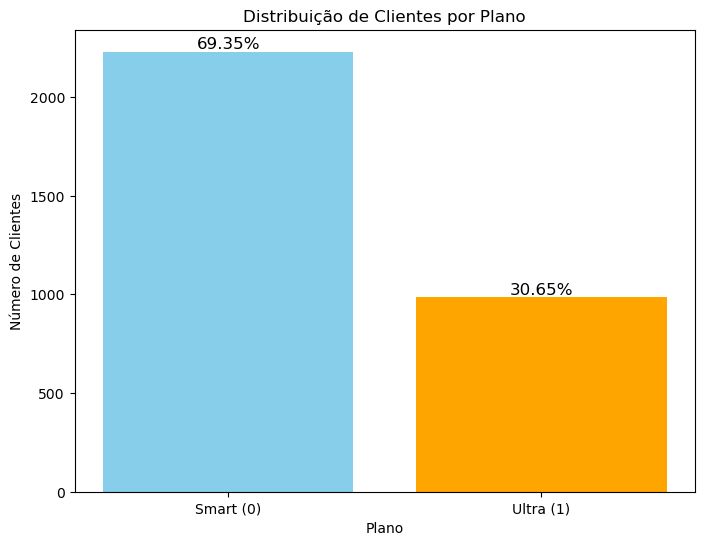

In [114]:
counts = df['is_ultra'].value_counts()
total = counts.sum()

percentages = (counts / total) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(counts.index, counts.values, color=['skyblue', 'orange'])

for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribuição de Clientes por Plano')
plt.xticks(ticks=[0, 1], labels=['Smart (0)', 'Ultra (1)'], rotation=0)
plt.xlabel('Plano')
plt.ylabel('Número de Clientes')
plt.show()

Essa diferença apresentada faz bastante sentido, visto que o plano smart é mais simples, certamente mais barato e, portanto, será mais procurado. A diferença que existe também não me parece ser suficiente para que exploremos mais afundo, temendo grandes impactos nos modelos. Por isso, vale seguirmos em frente.

##### Correlação

In [117]:
correlacao = df.corr()['is_ultra'].sort_values(ascending=False)

correlacao

is_ultra    1.000000
calls       0.207122
messages    0.207122
minutes     0.206955
mb_used     0.198568
Name: is_ultra, dtype: float64

Aqui, percebemos que todas as colunas têm uma correlação positiva com a coluna "is_ultra", indicando que todas têm sua influência na decisão de qual plano escolher, mas as magnitudes são baixas em todos os casos. isso nos indica, apenas, que nenhuma das colunas serve como forte preditor de qual plano será escolhido.

##### Comparando as Médias Entre os Planos

In [120]:
smart_plan = df[df['is_ultra'] == 0]
ultra_plan = df[df['is_ultra'] == 1]

variables = ['calls', 'minutes', 'messages', 'mb_used']
for var in variables:
    smart_mean = smart_plan[var].mean()
    ultra_mean = ultra_plan[var].mean()
    print(f"Média de {var} - Smart: {smart_mean:.2f}, Ultra: {ultra_mean:.2f}")

Média de calls - Smart: 58.46, Ultra: 73.39
Média de minutes - Smart: 405.94, Ultra: 511.22
Média de messages - Smart: 58.46, Ultra: 73.39
Média de mb_used - Smart: 16208.47, Ultra: 19468.82


In [121]:
for var in variables:
    stat, p = ttest_ind(smart_plan[var], ultra_plan[var], equal_var=False)
    print(f"Teste t para {var}: p-valor = {p:}")

Teste t para calls: p-valor = 1.884480185046945e-22
Teste t para minutes: p-valor = 1.3446735422636459e-22
Teste t para messages: p-valor = 1.884480185046945e-22
Teste t para mb_used: p-valor = 1.397720425700292e-20


O nosso p-valor ser menor do que 0.05 indica que há uma diferença significativa entre as médias de cada plano. Rejeitamos a hipótese nula de que não há. Essa diferença de médias é bem esperado. Na maioria esmagadora dos casos, só assina o plano ultra quem realmente precisa de mais serviços do que o plano smart oferece. O modelo de regressão logística deve ser o mais impactado por esses resultados, mas essa diferença é muito boa para modelos de árvore de decisão e floresta aleatória, que, de fato, apresentaram resultados maiores de acurácia os treinamentos.

##### Distribuição dos Dados por plano

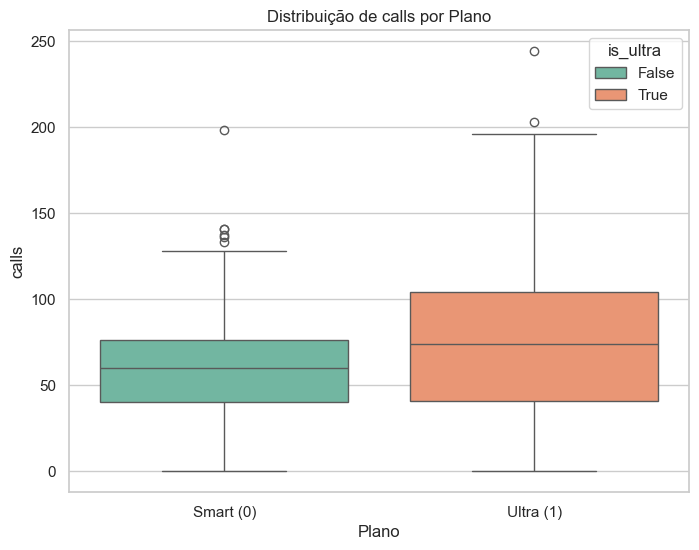

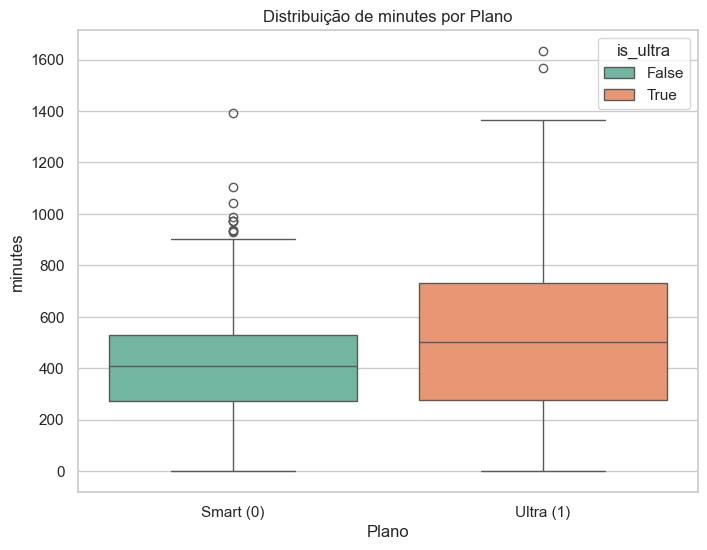

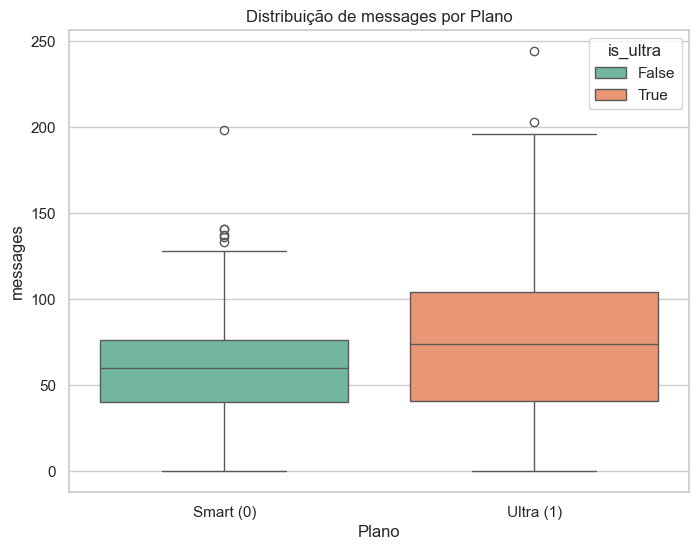

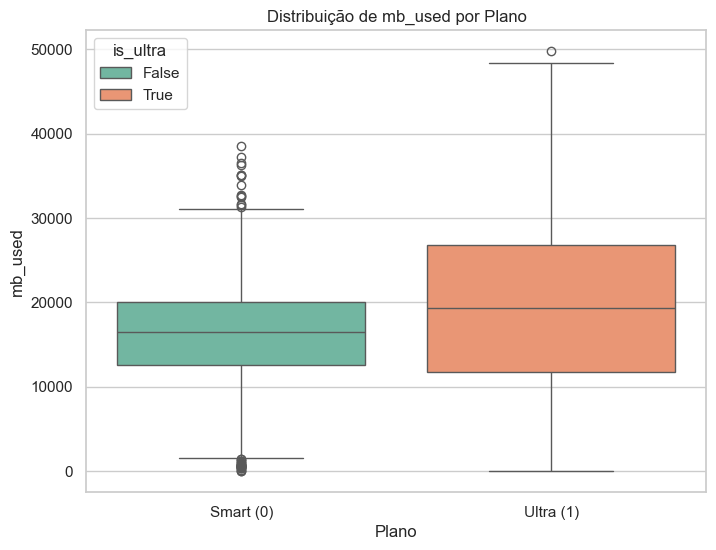

In [167]:
sns.set(style="whitegrid")

variables = ['calls', 'minutes', 'messages', 'mb_used']

for var in variables:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='is_ultra', y=var, data=df, hue='is_ultra', palette='Set2', dodge=False)
    plt.title(f'Distribuição de {var} por Plano')
    plt.xticks(ticks=[0, 1], labels=['Smart (0)', 'Ultra (1)'])
    plt.xlabel('Plano')
    plt.ylabel(var)
    plt.show()

Aqui, geramos um boxplot para cada coluna da tabela, buscando mais insights sobre o comportamento geral dos usuários de cada plano e tentando entender como os resultados vão afetar a análise e a predição de cada modelo. Percebemos que, em todos os casos, os números do plano ultra são superiores, o que já é esperado. Também fica claro que os usuários do plano smart têm mais outliers elevados, o que também faz sentido, considerando que, com limites menores, é muito mais fácil extrapolar os números quando susa um plano menor.

Todos os planos apresentam alguma sobreposição, sendo que, com exceçao de mb_used, todas elas são consideravelmente significativas. Isso não chega a ser muito problemático, mas dificulta o trabalho dos modelos treinados, porque valores intermediários dificultam a classificação, porque podem estar presentes em ambos os planos. para todos os modelos, mb_used terá mais impacto, porque é a coluna que mais apresenta variação de dados de um planoi para outro.

## 2. Divisão dos Dados

Agora, seguimos para a parte de divisão dos dados. Vamos deixar 60% do dataframe para treinamento do modelo. Outros 20% serão para validação. Os últimos 20% para testar o desempenho final dos modelos.

In [125]:
features = df.drop(columns=['is_ultra'])
target = df['is_ultra']

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size =0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

Nessa célula, fizemos a divisão. Antes de seguirmos, vamos só chamar um print e verificar se as divisões ficaram com aqs proporções corretas do dataframe

In [127]:
print(f"Tamanho do Treinamento: {len(features_train)}")
print(f"Tamanho da Validação: {len(features_valid)}")
print(f"Tamanho do Teste: {len(features_test)}")

Tamanho do Treinamento: 1928
Tamanho da Validação: 643
Tamanho do Teste: 643


Considerando o tamanho de 3214, os valores estão corretos. Nossa divisão funcionou perfeitamente. 

## 3. Treinando Nosso Modelos

Até aqui, nas aulas, treinamos modelos de árvore de decisão, floresta aleatória e regressão logística. Vamos criar um modelo de cada tipo e fazer os testes de acurácia e EQM pertinentes em cada um. Assim, saberemos qual deles apresenta o melhor desempenho.

### 3.1 Árvore de Decisão

Vamos começar criando um modelo de árvore de decisão. O primeiro passo é criar um range para profundidade da árvore e um valor para o número de amostra por folhas. Assim, teremos os dois hiperparâmetros já verificados. Por fim, testar a acurácia do modelo, considerando os melhores hiperparâmetros.

In [133]:
best_tree_model = None
best_tree_accuracy = 0
best_depth = 0
best_min_samples_leaf = 0

for depth in range(1, 11):
    for min_samples in range(1, 6):
        tree_model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples, random_state=12345)
        tree_model.fit(features_train, target_train)
        predictions_valid = tree_model.predict(features_valid)

        accuracy = accuracy_score(target_valid, predictions_valid)

        if accuracy > best_tree_accuracy:
            best_tree_model = tree_model
            best_tree_accuracy = accuracy
            best_depth = depth
            best_min_samples_leaf = min_samples

print(f"Melhor profundidade: {best_depth}")
print(f"Melhor número mínimo de amostras por folha: {best_min_samples_leaf}")
print(f"Acurácia com melhores parâmetros: {best_tree_accuracy:.2f}")

Melhor profundidade: 6
Melhor número mínimo de amostras por folha: 3
Acurácia com melhores parâmetros: 0.79


Aqui, o código funcionou perfeitamente. Criamos dois ciclos for para percorrer cada um dos valores de profundidade e quantidade de amostras por folha. A melhor acurácia que encontramos é de 0.79. Testar outros ranges para os hiperparâetros poderia nos levar a resultados melhores, mas isso também não é garantido e modificar demais esses valores pode deixar o processamento do código pesado demais ou nos levar a over/underfit. Como superamos o valor mínimo exigido no projeto, podemos seguir para o treinamento e teste de uma Floresta Aleatória. 

### 3.2 Floresta Aleatória

Agora, vamos treinar uma floresta aleatória. Vamos verificar os mesmos hiperparâmetrosa de profundidade e número de amostras por folha, mas tambémm vamos adicionar o número de indicadores e determinar o número de árvores na floresta.

In [137]:
best_forest_model = None
best_forest_accuracy = 0
best_n_estimators = 0
best_max_depth = 0
best_min_samples_leaf = 0

for n_estimators in range(50, 201, 50):
    for max_depth in range(5, 16, 5):
        for min_samples_leaf in range(1, 6):
    
            forest_model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=12345)
            
            forest_model.fit(features_train, target_train)
            
            predictions_valid = forest_model.predict(features_valid)
            
            accuracy = accuracy_score(target_valid, predictions_valid)
            
            if accuracy > best_forest_accuracy:
                best_forest_model = forest_model
                best_forest_accuracy = accuracy
                best_n_estimators = n_estimators
                best_max_depth = max_depth
                best_min_samples_leaf = min_samples_leaf

print(f"Melhor número de árvores: {best_n_estimators}")
print(f"Melhor profundidade máxima: {best_max_depth}")
print(f"Melhor número mínimo de amostras por folha: {best_min_samples_leaf}")
print(f"Acurácia com melhores parâmetros: {best_forest_accuracy:.2f}")


Melhor número de árvores: 100
Melhor profundidade máxima: 10
Melhor número mínimo de amostras por folha: 2
Acurácia com melhores parâmetros: 0.80


Aqui, terminamos os cálculos de acurácia para a Floresta de Decisão. Dessa vez, estabelecemos ranges especifícos com intervalos para serem avaliados, porque verificar todos os valores dentro de ranges muito grandes explodiria meu computador. Nessa parte, eu fiz um teste, criando um novo ciclo for que, depois de selecionado o melhor intervalo, verificava, dentro desse intervalo, o melhor valor. Ficou muito pesado e a melhora na acurácia foi de apenas 0.01, saltando de 0.80 para 0.81. Excluí essa parte, porque não julguei que a melhora justificava os novos cálculos. Só essa última célula já demorou o suficiente para carregar. 

Até aqui, percebenmos que a floresta aloeatória tem a melhor acurácia, mas a dificuldade no processamento já foi considerável. Valeria a pena entender com o cliente qual a capacidade de processamento deles. Se ela for limitada, a árvore de decisão é melhor, apesar da queda mínima em acurácia.

### 3.3 Regressão Logística

In [188]:
logistic_model = LogisticRegression(solver='liblinear', random_state=12345, max_iter=1000)

logistic_model.fit(features_train, target_train)

logistic_predictions = logistic_model.predict(features_valid)

logistic_accuracy = accuracy_score(target_valid, logistic_predictions)

print(f"Acurácia da Regressão Logística: {logistic_accuracy:.2f}")

Acurácia da Regressão Logística: 0.71


A regressão logística apresentou uma acurácia de 0.71. Isso é abaixo do resultado pedido pelo projeto e já é um grande indicativo de que este não é o melhor modelo para essa tarefa. Esses resultados também batem com algumas das análises feitas anteriormente, que destacavam algumas vantagens do Modelo de árvore de decisão e de floresta aleatória para essa tarefa. Agora, nos resta treinar os modelos novamente e fazer predições com os dados de validação, como o "segundo passo" dos testes gerais dos modelos. Aqui vamos nós.

## 4 Fazendo Predições com os Dados de Validação

### 4.1 Validando a Árvore de Decisão

In [181]:
best_tree_model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, random_state=12345)
best_tree_model.fit(features_train, target_train)

predictions_valid = best_tree_model.predict(features_valid)
validation_accuracy = accuracy_score(target_valid, predictions_valid)

print(f"Acurácia no conjunto de validação: {validation_accuracy:.2f}")


Acurácia no conjunto de validação: 0.79


A árvore de decisão apresentou exatamente a mesma acurácia no treinamento e na validação. Esse é o melhor resultado que poderíamos esperar agora, já que estamos querendo evitar overfitting e underfitting. Até aqui, tudo indica que o modelo passará pelos dados de teste sem problemas. Antes de testar isso, vamos verificar se a acurácia da floresta aleatória e da regressão logística também será mantida.

### 4.2 Validando a Floresta Aleatória

In [185]:
best_forest_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_leaf=2, 
    random_state=12345
)
best_forest_model.fit(features_train, target_train)

predictions_valid = best_forest_model.predict(features_valid)
validation_accuracy = accuracy_score(target_valid, predictions_valid)

print(f"Acurácia no conjunto de validação: {validation_accuracy:.2f}")

Acurácia no conjunto de validação: 0.80


Mias uma vez, o resultado obtido no conjunto de validação é exatamente igual ao obtido no treinamento. Isso é exatamente o que queremos. Seguindo esse padrão, o melhor modelo para a empresa Megaline será o de Floresta Aleatória. Mas antes de cravar qualquer resultado, vamos seguir com a validação.

### 4.3 Validação da Regressão Logística

In [194]:
logistic_model = LogisticRegression(solver='liblinear', random_state=12345, max_iter=1000)
logistic_model.fit(features_train, target_train)

logistic_predictions_valid = logistic_model.predict(features_valid)
validation_accuracy = accuracy_score(target_valid, logistic_predictions_valid)

print(f"Acurácia no conjunto de validação: {validation_accuracy:.2f}")

Acurácia no conjunto de validação: 0.71


Mais uma vez, o resultado foi o mesmo (apesar de que para a regressão logísticva ficou abaixo dos 0.75) Tudo indica que esse modelo será descartado.

## 5 Verificando os Modelos no Conjunto de Dados de Teste

### 5.1 Árvore de Decisão

In [202]:
final_tree_model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, random_state=12345)
final_tree_model.fit(features_train, target_train)

# Avaliando no conjunto de teste
predictions_test = final_tree_model.predict(features_test)
test_accuracy = accuracy_score(target_test, predictions_test)

# Exibindo o resultado
print(f"Acurácia no conjunto de teste (Árvore de Decisão): {test_accuracy:.2f}")

Acurácia no conjunto de teste (Árvore de Decisão): 0.77


Aqui, apresentamos uma leve queda de acurácia, mas 0.02, nesse cenário não é uma queda significativa o suficiente e está acima do valor mínimo pedido pelo projeto. Considerando o cenário geral, podemos seguir em frente, porque atendemos aos requisitos.

### 5.2 Floresta Aleatória

In [206]:
final_forest_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_leaf=2, 
    random_state=12345)
final_forest_model.fit(features_train, target_train)

forest_predictions_test = final_forest_model.predict(features_test)
forest_test_accuracy = accuracy_score(target_test, forest_predictions_test)

print(f"Acurácia no conjunto de teste (Floresta Aleatória): {forest_test_accuracy:.2f}")

Acurácia no conjunto de teste (Floresta Aleatória): 0.79


Neste teste, a Floresta Aleatória também apresentou uma pequena queda, dessa vez, ainda menor, e registrou uma acurácia de 0.79. Mais uma vez, a queda não é significativa e mantém o modelo dentro dos requisitos. Tudo indica que este será nosso modelo vencedor! 

### 5.3 Regressão Logística

In [210]:
final_logistic_model = LogisticRegression(solver='liblinear', random_state=12345, max_iter=1000)
final_logistic_model.fit(features_train, target_train)

logistic_predictions_test = final_logistic_model.predict(features_test)
logistic_test_accuracy = accuracy_score(target_test, logistic_predictions_test)

print(f"Acurácia no conjunto de teste (Regressão Logística): {logistic_test_accuracy:.2f}")

Acurácia no conjunto de teste (Regressão Logística): 0.68


O nosso pior modelo foi o que apresentou a maior queda. Como esperado, vamos descartar essa regressão, que obteve valores fracos e distantes dos outros dois concorrentes

## Conclusão

Chegamos ao final de mais um projeto! Nosso modelo vencedor é o Modelo de Floresta Aleatória, que passou por todos os testes com valores acima dos exigidos e finalizou o trabalho com acurácia de 0.79! Nosso segundo melhor foi a Árvore de Decisão, que terminou com 0.77. Já a regressão logística se mostrou ineficaz e nem atingiu o valor mínimo pedido pelo projeto. O resultado final ficou em 0.68. 

Nesse projeto, trabalhei com os principais parâmetros apresentados nas lições da TripleTen. Analisando a tarefa proposta, entendi que esse se tratava de um modelo de classificação, por isso a acurácia foi o valor determinante para o resultado. Não calculei o MSE, porque entendo que essa métrica só é realmente efetiva em modelos de regressão. 

No momento de análise dos dados, tentei guiar o projeto de forma a criar gráficos e representações visuais que pudessem ser interessantes e que eu entendia que teriam impacto no trabalho dos modelos. Também busquei treinar o teste de hipótese, mesmo que ela parecesse óbvia. De qualquer forma, como os resultados apresentados pelos modelos atingiam os valores esperados, não fiz nenhuma alteração no conjunto de dados. As melhores práticas nesse sentido não foram trabalhadas pela Tripleten e tais alterações, mais uma vez, não se mostraram necessárias.